# Abin Sur - 
 - the alien that gave Hal Jordan his Green Lantern Power Ring.

Use real data like `zen.2458098.58037.xx.HH.uv` and `zen.2458098.58037.xx.HH.uv.abs.calfits` to generate training data that in more realistic, then train a network on that data and test it.

In [1]:
import hera_cal as hc
import pyuvdata
import aipy
import uvtools

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys, io
import tensorflow as tf

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
import time

In [6]:
def clean_phase(num_entries = 10000, tau_low = -0.01, tau_high = 0.01):

    # random.uniform is half open [low, high) not sure if that matters
    tau = np.random.uniform(low = tau_low, high = tau_high, size = num_entries) 
    nu = np.arange(1024)
    
    clean_phase_data = np.empty((num_entries, 1024))
    for i in range(num_entries):
        clean_phase_data[i] = np.angle(np.exp(2*np.pi*1j * (tau[i]*nu + np.random.uniform())))
    
    return clean_phase_data, tau.reshape(-1, 1)

In [7]:
def gen_plot(predicted_values, actual_values, output_scaler):
    """Create a prediction plot and save to byte string."""
    
    prediction_unscaled = output_scaler.inverse_transform(predicted_values)
    actual_unscaled = output_scaler.inverse_transform(actual_values)

    sorting_idx = np.argsort(actual_unscaled.T[0])
        
    fig, ax = plt.subplots(figsize = (5, 3), dpi = 144)

    ax.plot(prediction_unscaled.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1,
            color = 'darkblue')
    
    ax.plot(actual_unscaled.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1, alpha = 0.50,
            color = '#E50000')       
    
    ax.set_title('std: %.9f' %np.std(prediction_unscaled.T[0][sorting_idx] - actual_unscaled.T[0][sorting_idx]))
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi = 144)
    plt.close(fig)
    buf.seek(0)

    return buf.getvalue()



In [8]:
# load in data for a JD. 
data_directory = '../zen_data/'
miriad_path = data_directory + 'zen.2458098.58037.xx.HH.uv'

uvd = pyuvdata.UVData()
uvd.read_miriad(miriad_path)

# gains for same data 
calfits_path = data_directory + 'zen.2458098.58037.xx.HH.uv.abs.calfits'
gains, flags = hc.io.load_cal(calfits_path)

In [9]:
# get the redundancies for that data
aa = hc.utils.get_aa_from_uv(uvd)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

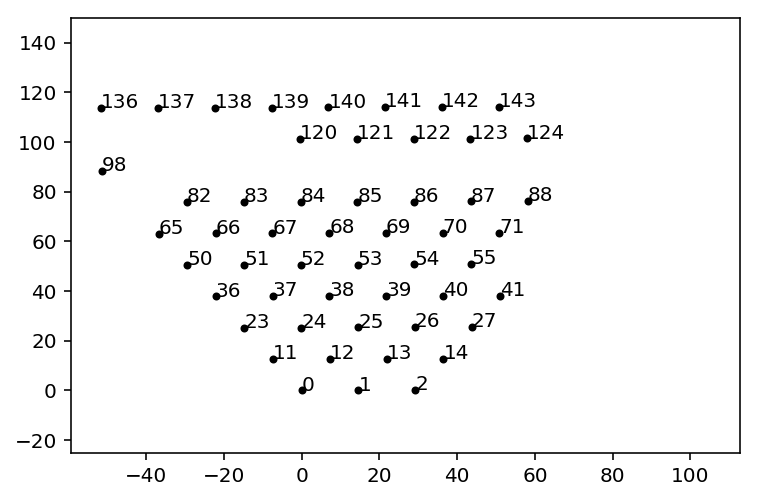

In [10]:
# take a look at the array, just because
antpos = np.array([aa.get_baseline(0, i, src = 'z') for i in range(len(aa.ants))]) * aipy.const.len_ns / 100.
x , y, _ = antpos.T
plt.plot(x, y, 'k.')
for ant, (xi, yi) in enumerate(zip(x,y)):
    if -25 < yi < 150:
        plt.text(xi,yi, str(ant))
plt.ylim(-25,150)
plt.show()

***
- want to make it so I can randomly choose a baseline vector and a random combination of antennas for that baseline.

In [11]:
def sep_combos(separation = (0,1), uvd = pyuvdata.uvdata.UVData, gain_keys = [], red_bls = []):
    """Get all the good pair combinations for a separation """
    
    # antenna pairs with baseline vector in common with some separation
    seps = [bl for bl in red_bls if separation in bl][0]

    # data for those pairs
    data = {bl: uvd.get_data(bl) for bl in seps}

    # eliminate the bad antennas by comparing the gains to the pairs
    good_ants = [a[0] for a in gain_keys]
    good_seps = [sep for sep in seps if ((sep[0] in good_ants) and (sep[1] in good_ants))]

    # get all the unique combinations of the good pairs
    good_sep_combos = list(itertools.combinations(good_seps,2))
    
    return sorted(good_sep_combos)

In [12]:
# get all the good separations
# this has to be like the stupidist possible way to do this ...
good_bl = []
all_seps = list(itertools.combinations(np.arange(144),2))
for test_sep in all_seps:
    try:
        if len(sep_combos(separation = test_sep, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)) > 1:
            good_bl.append(test_sep)
    except:
        pass

For example:

(51, 87)
((23, 55), (83, 123))


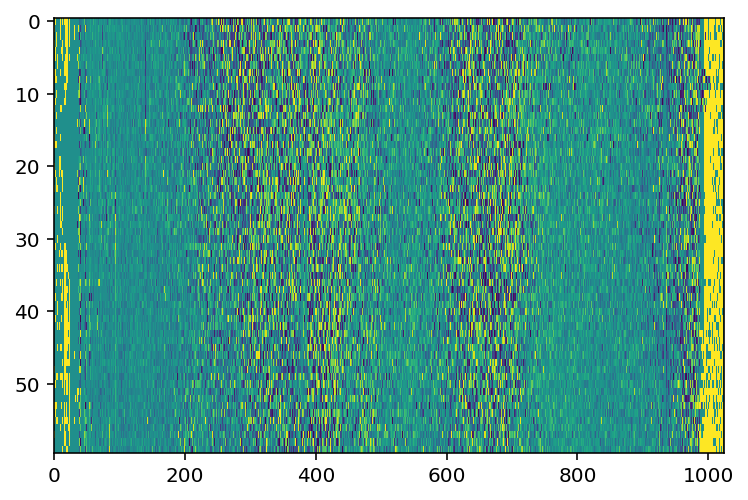

In [13]:
rand_bl = good_bl[np.random.choice(range(len(good_bl)))]
print(rand_bl)

data = {bl: uvd.get_data(bl) for bl in [bl for bl in red_bls if (rand_bl) in bl][0]}

rand_set_sep_combos = sep_combos(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)
rand_idx = np.random.choice(range(len(rand_set_sep_combos)))
rand_sep_combo = rand_set_sep_combos[rand_idx]
print(rand_sep_combo)

# generate a random flatness 
c_num = np.random.randint(low = 0, high = len(rand_sep_combo))

a, b = rand_sep_combo[0][0], rand_sep_combo[0][1]
c, d = rand_sep_combo[1][0], rand_sep_combo[1][1]

S = data[a, b]*data[c, d].conjugate() * gains[(a,'x')].conjugate() * gains[(b,'x')] * gains[(c,'x')] * gains[(d,'x')].conjugate()

uvtools.plot.waterfall(S, mode = 'phs')
plt.show()

I'm calling this type of thing a flatness, a 60 by 1024 set of data.
And then use that as base to generate data 

0.00119865352224


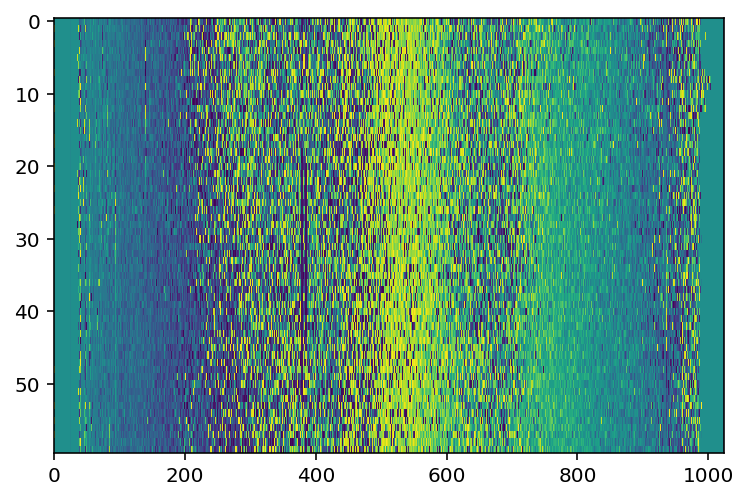

In [19]:
delay = np.random.uniform(low = -.040, high = 0.040) # should be about 5 wraps
nu = np.arange(1024)

uvtools.plot.waterfall(S * np.exp(-2*np.pi*1j*(delay*nu + 0)), mode = 'phs')
print(delay)
plt.show()

In [20]:
def batch(flatness, delay, nu = np.arange(1024), rand_phase = 0):
    """Take in a flatness and delay and generate a small training batch"""
    return flatness * np.exp(-2*np.pi*1j*(delay*nu + rand_phase))

In [21]:
def gen_flatness(separation = (0,1), uvd = pyuvdata.uvdata.UVData, gain_keys = [], red_bls = []):
    """Take in a separation baseline, UVD, gainkeys, and redundant  baselines and generate a 'flatness'"""
    
    data = {bl: uvd.get_data(bl) for bl in [bl for bl in red_bls if (rand_bl) in bl][0]}

    rand_set_sep_combos = sep_combos(separation = separation, uvd = uvd, gain_keys = gain_keys, red_bls = red_bls)
    rand_idx = np.random.choice(range(len(rand_set_sep_combos)))
    rand_sep_combo = rand_set_sep_combos[rand_idx]

    a, b = rand_sep_combo[0][0], rand_sep_combo[0][1]
    c, d = rand_sep_combo[1][0], rand_sep_combo[1][1]
    
    return  data[a, b]*data[c, d].conjugate() * gains[(a,'x')].conjugate() * gains[(b,'x')] * gains[(c,'x')] * gains[(d,'x')].conjugate()

In [22]:
perfectly_flat = np.ones((60,1024))

*** 
Lets takea. look at a bunch of different flatnesses

(36, 83)


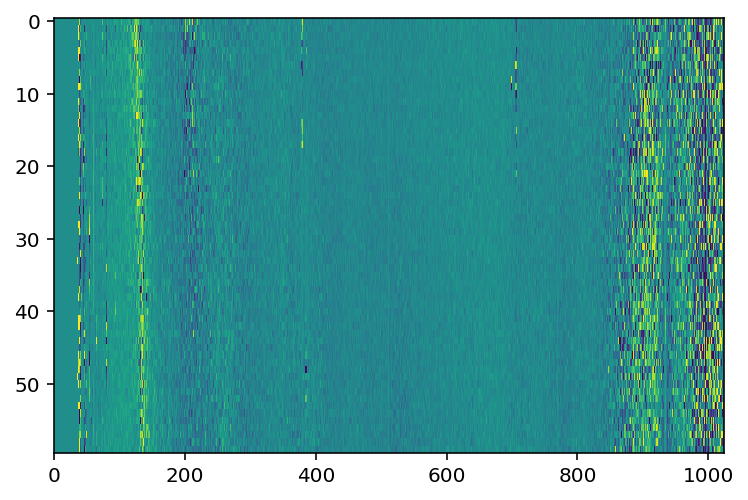

(13, 120)


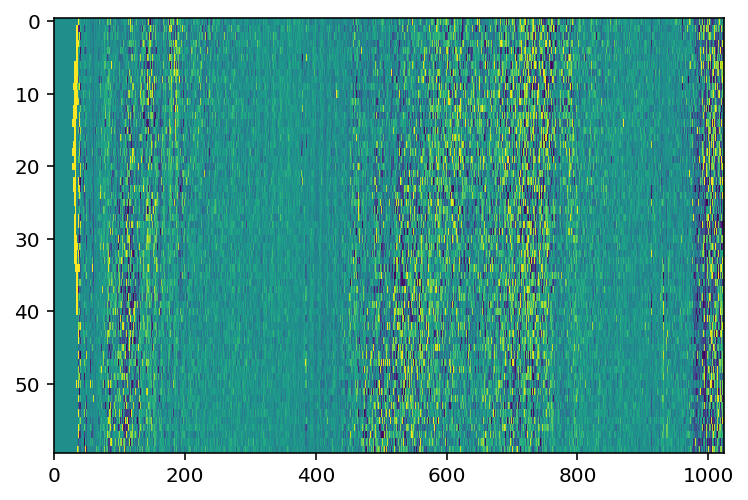

(98, 136)


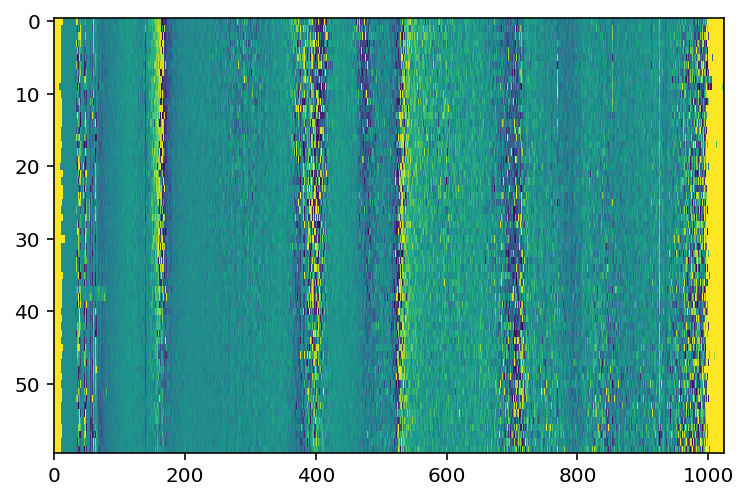

(1, 55)


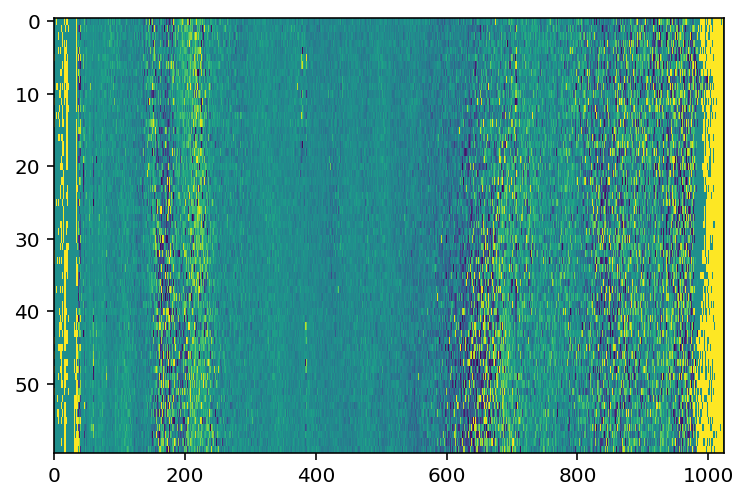

(2, 27)


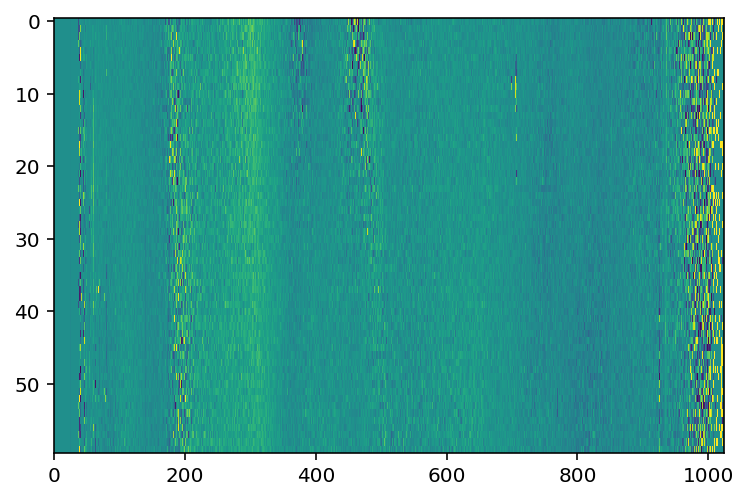

(0, 54)


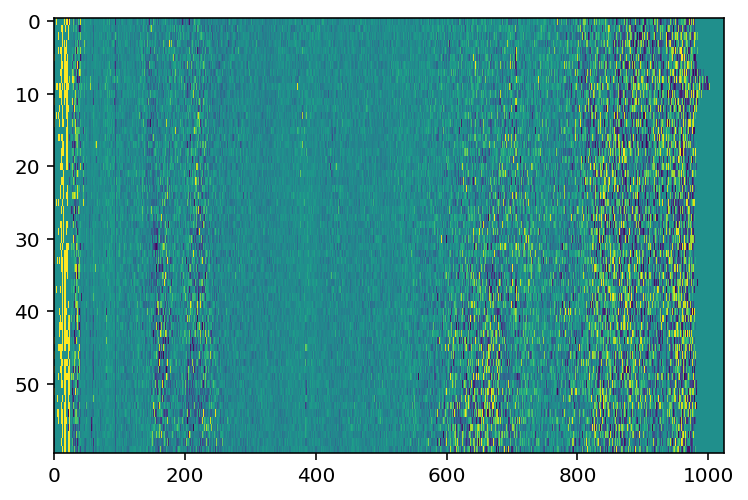

(121, 138)


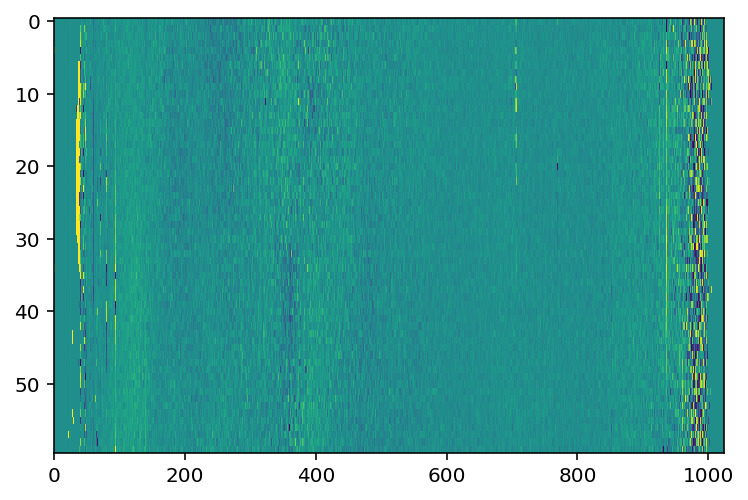

(66, 85)


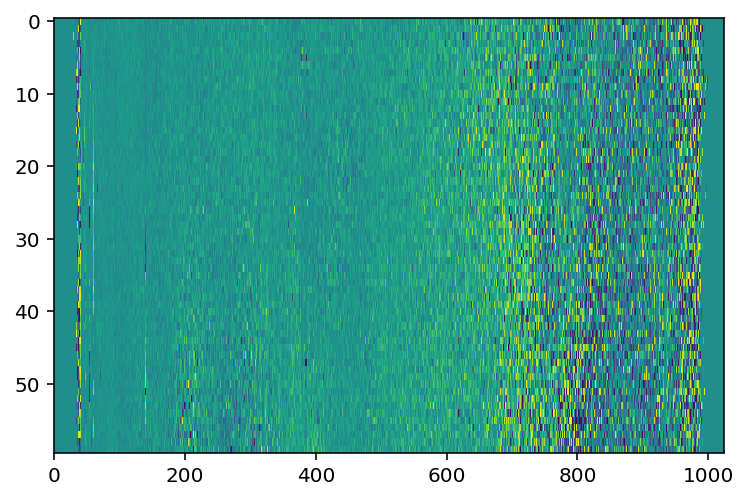

(136, 142)


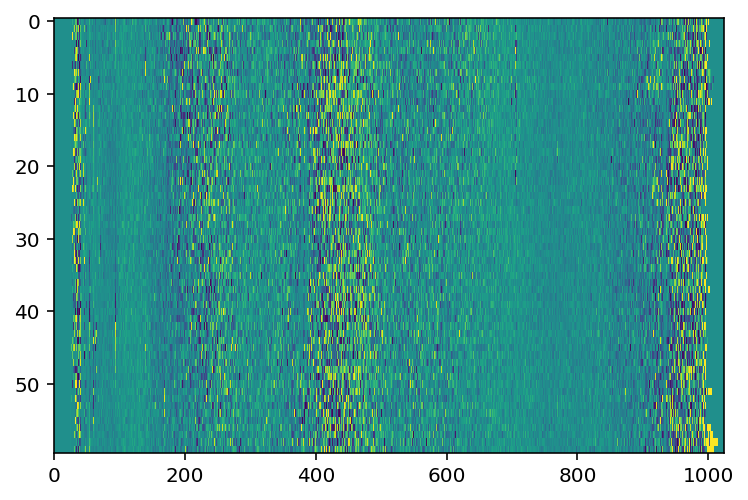

(26, 41)


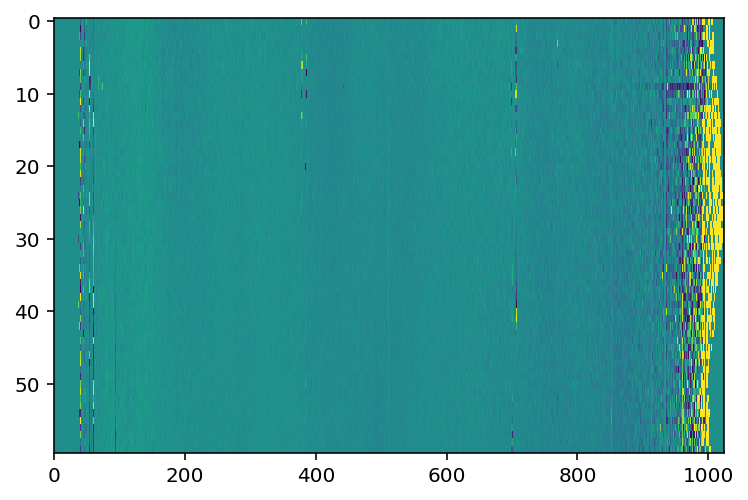

In [108]:
# 5 by 5
i = 0
while(i < 10):
    
    rand_bl = good_bl[np.random.choice(range(len(good_bl)))]
    S = gen_flatness(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)

    uvtools.plot.waterfall(S, mode = 'phs')
    print(rand_bl)
    i += 1
    plt.show()

Some of them are flatter than others. This is theoretically okay.

Lets see how different flatnesses effect (affect ?) the same delay.

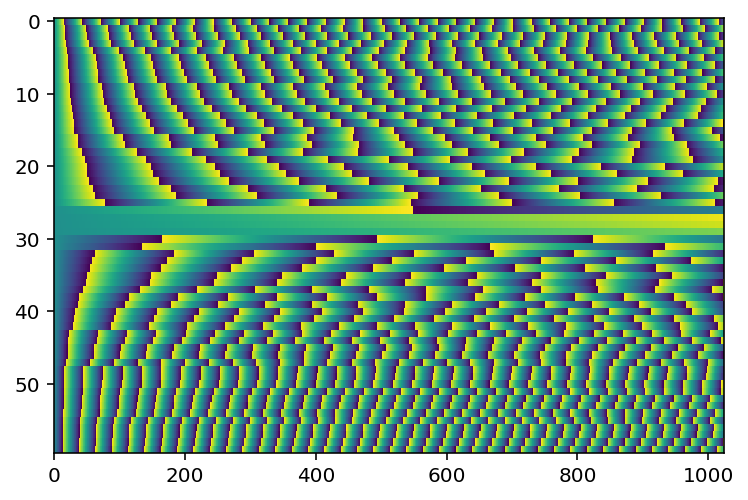

In [26]:
delay = sorted(np.random.uniform(low = -.040, high = 0.040, size = (60, 1)))
S = perfectly_flat
delay_batch = S * batch(S, delay)
uvtools.plot.waterfall(delay_batch, mode = 'phs')
plt.show()

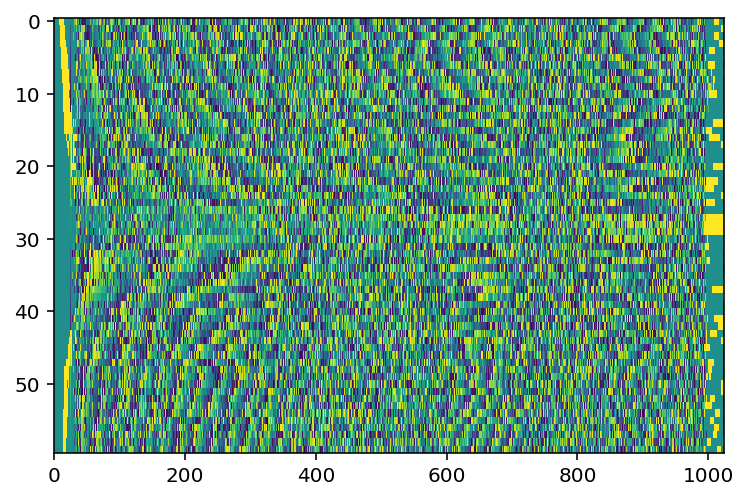

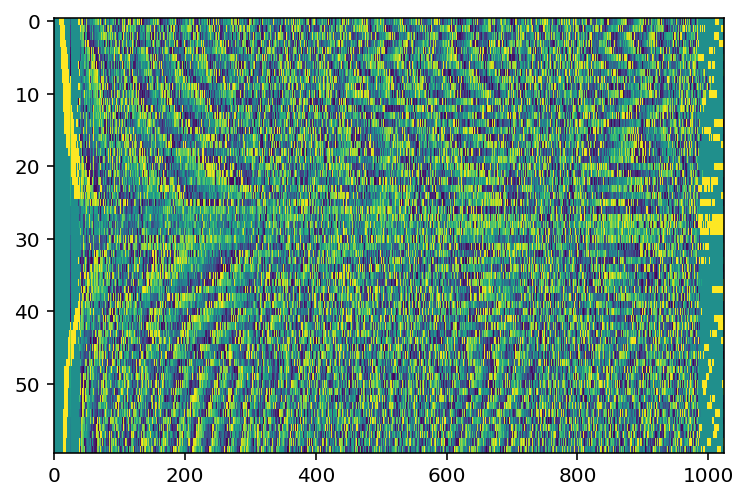

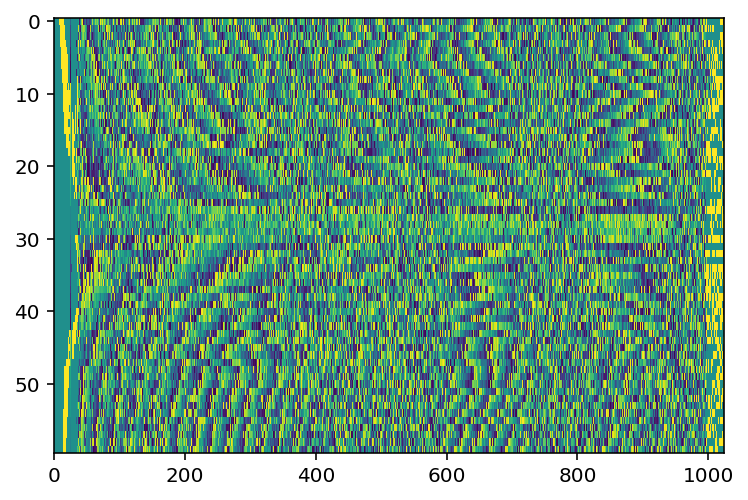

In [27]:
rand_bl = good_bl[np.random.choice(range(len(good_bl)))]
S = gen_flatness(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)
delay_batch = S * batch(S, delay)
uvtools.plot.waterfall(delay_batch, mode = 'phs')
plt.show()
S = gen_flatness(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)
delay_batch = S * batch(S, delay)
uvtools.plot.waterfall(delay_batch, mode = 'phs')
plt.show()
S = gen_flatness(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)
delay_batch = S * batch(S, delay)
uvtools.plot.waterfall(delay_batch, mode = 'phs')
plt.show()

We see that we can get different representations for the same delay. Some of the baselines generate many different flatnesses, others few. 

In [28]:
def epoch_data(delays, flatness):
    """Take in a list of delays and a flatness and make a large batch.. ? not sure why i did it like this.."""
    
    for i, delay in enumerate(delays):
        if i == 0:
            delay_batch = S * batch(S, delay, rand_phase = np.random.uniform())
            delay_col = np.ones((60,1))*delay
        else:
            delay_batch = np.vstack((delay_batch, S * batch(S, delay, rand_phase = np.random.uniform())))
            delay_col = np.vstack((delay_col, np.ones((60,1))*delay))
        sys.stdout.write('\r%d'%i)
        
    return np.angle(delay_batch), delay_col

***

In [29]:
number_of_inputs  = 1024
number_of_outputs =  1
layer_nodes = [512,256,128,128,128,64,64,32,32]
learning_rate = 0.0001
testing_data_percentage = 0.20
keep_prob_rate = 0.50
model_save_interval = 50

In [33]:
num_epochs = 500
num_batches = 4

In [31]:
class Barry_Allen(object):
    """A neural network of fully connected LeakyReLU layers. Dropout between input layer and first hidden layer."""
    
    def __init__(self, layer_nodes, number_of_inputs, number_of_outputs, learning_rate):
        
        tf.reset_default_graph()
        
        with tf.variable_scope('input_X'):
            self.X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
        with tf.variable_scope('input_y'):
            self.y  = tf.placeholder(tf.float32, shape = (None, 1))
            
        with tf.variable_scope('keep'):
            self.keep_prob = tf.placeholder(tf.float32)
            
        layers = []
        with tf.variable_scope('input_layer'):
            b = tf.get_variable(name = 'biases_input',
                                shape = [layer_nodes[0]],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = 'weights_input',
                                shape  = [number_of_inputs, layer_nodes[0]],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            layer = tf.nn.leaky_relu(tf.matmul(self.X, w) + b)
            layers.append(layer)
        
        with tf.variable_scope('dropout'):
            dropout = tf.nn.dropout(layers[0], self.keep_prob)            
            layers.append(dropout)
            
        # hidden layers
        for i in range(len(layer_nodes)):
            if i > 0:
                with tf.variable_scope('layer_%d' %i):
                    b = tf.get_variable(name = 'biases_%d' %i,
                                        shape = [layer_nodes[i]],
                                        initializer = tf.zeros_initializer())
                    
                    w = tf.get_variable(name = 'weights_%d' %i,
                                        shape  = [layer_nodes[i-1], layer_nodes[i]],
                                        initializer = tf.contrib.layers.xavier_initializer())
                    
                    layer = tf.nn.relu(tf.matmul(layers[i], w) + b)
                    layers.append(layer)
                    
        with tf.variable_scope('output_layer'):
            b = tf.get_variable(name = "biases_out",
                                shape = [number_of_outputs],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = "weights_out",
                                shape  = [layer_nodes[-1], number_of_outputs],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            self.prediction = tf.nn.relu(tf.matmul(layers[-1], w) + b)
            
        with tf.variable_scope('cost'):
            self.cost = tf.reduce_mean(tf.squared_difference(self.prediction, self.y))
            
        with tf.variable_scope('train'):
            self.optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(self.cost)

        with tf.variable_scope('image'):
            self.image_buf = tf.placeholder(tf.string, shape=[])
            epoch_image = tf.expand_dims(tf.image.decode_png(self.image_buf, channels=4), 0)
    
        with tf.variable_scope('logging'):
            
            tf.summary.image('prediction_vs_actual', epoch_image)
            tf.summary.histogram('predictions', self.prediction)
            tf.summary.scalar('current_cost', self.cost)

            self.summary = tf.summary.merge_all()

In [32]:
network = Barry_Allen(layer_nodes,number_of_inputs, number_of_outputs, learning_rate)

In [ ]:
log_direc = 'logs/Barry_Allen_A'
saver = tf.train.Saver()

with tf.Session() as session:

    session.run(tf.global_variables_initializer())
#     saver.restore(session,'Delilah/trained_model.ckpt-199')
    
    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'    
    testing_cost = 0

    
    for epoch in range(num_epochs):
        
        # each epoch a new S for training.
        rand_delays = np.random.uniform(low = -0.0400, high = 0.0400, size = (60,1))
        rand_bl = good_bl[np.random.choice(range(len(good_bl)))]
        S = gen_flatness(separation = rand_bl, uvd = uvd, gain_keys = gains.keys(), red_bls = red_bls)
        delay_batch = S * batch(S, rand_delays, rand_phase = np.random.uniform())
        delay_col = rand_delays.reshape(-1,1)
        
        inputs, outputs = np.angle(delay_batch), delay_col
            
            
        # scale data
        
        input_scaler  = MinMaxScaler(feature_range = (0,1))
        output_scaler = MinMaxScaler(feature_range = (0,1))
        scaled_input  =  input_scaler.fit_transform(inputs)
        scaled_output = output_scaler.fit_transform(outputs)
        
        #split data 
        X_train, X_test, y_train, y_test = train_test_split(scaled_input, scaled_output,
                                                test_size = testing_data_percentage,
                                                random_state = np.random.seed(int(time.time())))
        

        # break training data into batches
        split_permutation = np.random.permutation(X_train.shape[0])
        X_train_batches = np.vsplit(X_train[split_permutation], num_batches)
        y_train_batches = np.vsplit(y_train[split_permutation], num_batches)

        # train on batches
        for i in range(num_batches):
            session.run(network.optimizer,
                        feed_dict = {network.X: X_train_batches[i], 
                                     network.y: y_train_batches[i], 
                                     network.keep_prob : keep_prob_rate})
            sys.stdout.write('\repoch: {:4.0f} -- testing_cost: {:2.10f}'.format(epoch, testing_cost))

        # training summaries
        prediction_scaled_test = session.run(network.prediction,
                                             feed_dict = {network.X: X_train,
                                                          network.keep_prob : 1.00})

        training_cost, training_summary = session.run([network.cost, network.summary],
                                                      feed_dict = {network.X: X_train,
                                                                   network.y: y_train,
                                                                   network.keep_prob : 1.00,
                                                                   network.image_buf: gen_plot(prediction_scaled_test,
                                                                                               y_train, output_scaler)})
        training_writer.add_summary(training_summary, epoch)
        training_writer.flush()  

         # testing summaries
        prediction_scaled_test = session.run(network.prediction,
                                             feed_dict = {network.X: X_test,
                                                          network.keep_prob : 1.00})

        testing_cost, testing_summary = session.run([network.cost, network.summary],
                                                    feed_dict = {network.X: X_test,
                                                                 network.y: y_test,
                                                                 network.keep_prob : 1.00,
                                                                 network.image_buf: gen_plot(prediction_scaled_test,
                                                                                             y_test, output_scaler)})
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()

        # message
        sys.stdout.write('\repoch: {:4.0f} -- testing_cost: {:2.10f}'.format(epoch, testing_cost))

        # save model
        if (epoch + 1) % model_save_interval == 0:
            saver.save(session, model_save_location, epoch)

    # save last model
    saver.save(session, model_save_location, epoch)

epoch:  164 -- testing_cost: 0.0853281841

0